# Algorithmic Trading Strategy Challenge

Name: Joshua Hizgiaev

In this challenge, your task is to design an algorithmic trading strategy using the stocks in the provided portfolio.
    
You may use yfinance to source data for the stocks within the period defined in the dummy_data.xlsx file.

You are not allowed to use a simple "buy and hold" strategy. Be creative and implement a more complex strategy that will maximize profit and minimize risk.

Your solution can be based on machine learning, technical analysis, or any other approach you find suitable.

Be creative and demonstrate your coding ability in this challenge.

In addition to implementing your strategy during this time period, you will also need to graph the profit/loss and liquidity ratio of the strategy over time.

Feel free to add code blocks and markdown blocks as needed, however, ensure specified logic is contained within their respective headers in the notebook.


## Assumptions, notes, and anything else I deam necessary to understand my code:
1. Based upon the instructions provided: "...where you source yfinance data for the time period defined in the uncleaned data frame for one or more of the equities defined" I will be choosing the first 5 equities within the portfolio to apply my strategy on, however, due to time constraints I can only apply my strategy to 1 equity provided that I have a large sum of capital. Ideally this would be applied to 5 equities I choose to diversify my portfolio. But for the purposes of submission only 1 stock was used.
2. Secondly I am assuming that trading begins **AT THE END OF JUNE** and not at the end of July provided that I begin with 200,000 dollars of capital at the end of June just like as required in my portfolio analysis.
3. I am using the cleaned data from the portfolio analysis, however this does not affect the overall strategy as I simply need the stocks provided in the portfolio.
4. I used google colab to complete this challenge due to ease of use and not needing to use my local Miniconda+Jupyter Environment.

## Strategy Implementation

### Add necessary imports:

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import datetime as dt
# Override pdr using yfinance
yf.pdr_override()
# Set default plot styling
plt.style.use('fivethirtyeight')
# Set default figsize params
plt.rcParams['figure.figsize'] = (20,10)

### Import google drive (If utilizing google colab):

In [2]:
from google.colab import drive
drive.mount('/content/MyDrive/')

Mounted at /content/MyDrive/


### Create a an algorithmic trader class:
My inspiration for using the strategy comes from the following links:

https://medium.com/codex/using-python-to-create-an-innovative-trading-strategy-and-achieve-better-results-702dcf4359ce

https://www.investopedia.com/articles/trading/08/macd-stochastic-double-cross.asp

https://www.linkedin.com/pulse/mastering-moving-average-crossover-strategies-comprehensive-guide/?trk=article-ssr-frontend-pulse_more-articles_related-content-card

In [6]:
# Need floor function for simple backtest
from math import floor

class DoubleCross:

  def __init__(self, data_path,initial_capital):
    """
    Constructor will essentialy read all stocks from a given portfolio (either multipage or not) by way
    of an excel file and extract the range of trading and all stock tickers within the excel file
    """
    # Read the excel data
    self.data = pd.read_excel(data_path, sheet_name=None)
    # Set the initial capital of the trading strategy
    self.initial_capital = initial_capital
    # Get the trading range from the given data sheet
    self.trade_range = self.parse_dates()
    # Get a list of the first 5 stocks present in the portfolio
    self.stocks = self.parse_stocks()

  def parse_dates(self):
    '''
    parse_dates returns a tuple of two dates in Year-Month-Day format to
    represent the range interval of trading
    '''
    # Get all dates from data by having them as a list of keys since every key in the pandas dictionary is a date
    keys = list(self.data.keys())
    # Parse the first and last date at that represents our range of trading
    dates = (dt.datetime.strptime(keys[0],'%Y-%m-%d'),dt.datetime.strptime(keys[-1],'%Y-%m-%d'))
    return dates

  def parse_stocks(self):
    """
    parse_stocks will take in a dataframe dictionary and extract the first 5
    equities present within the portfolio
    """
    stocks = set() # Set as a set so we only store unique tickers
    for sheet in self.data:
      # the list of stocks will essentially just be the first column of every sheet in the execel file
      for i in range(len(self.data[sheet])-1):
        # Stop after finding the first 5 stocks, in this case for the dummy portfolio these are noticably high value tech stocks
        stocks.add(self.data[sheet].iloc[i,0])
    print(list(stocks))
    return list(stocks)

  def get_historical_data(self,stock_index):
    """
    get_historical_data will simply grab the historical data
    """
    symbol = self.stocks[stock_index]
    # Use yfinance to get the open high low close and volume
    # Begin trading at THE END OF JUNE
    left = dt.date(2022,1,30)
    stock_data = pdr.get_data_yahoo(symbol,left,self.trade_range[1])
    # drop the adj_close column as I dont need it
    stock_data = stock_data.drop(['Adj Close'],axis=1)
    return stock_data

  def get_stoch_osc(self,high,low,close,k_lookback,d_lookback):
    """
    get_stoch_osc will compute the %K and %D line for the Stochastic
    Oscillator indicator and then return both as a tuple, this function will
    be applied to the low
    """
    lowest_low = low.rolling(k_lookback).min()
    highest_high = high.rolling(k_lookback).max()
    k_line = ((close - lowest_low) / (highest_high - lowest_low)) * 100
    d_line = k_line.rolling(d_lookback).mean()
    return k_line,d_line

  def get_positions(self,stoch_macd_signal):
    """
    get_positions will return a list representing all points where we
    hold a stock or a 0 if we dont own or hold the stock
    """
    position = []
    for i in range(len(stoch_macd_signal)):
      if stoch_macd_signal[i] > 1:
        position.append(0)
      else:
        position.append(1)

    for i in range(len(self.trade_data['Close'])):
      if stoch_macd_signal[i] == 1:
        position[i] = 1
      elif stoch_macd_signal[i] == -1:
        position[i] = 0
      else:
        position[i] = position[i-1]

    return position

  def init_trade(self):
    """
    init_trade would layout all the key data required for the equity under the trade strategy
    by applying the Stochiastic Osccilator and MACD towards the stock tickers we get from the portfolio,
    currently it only applies the strategy towards one stock (one equity). However given the time this can
    easily be applied towards multiple stocks at once. However my submission trade strategy will apply to only
    1 stock with all 200,000 of capital.
    """
    # Grab the historical stock data
    self.trade_data = self.get_historical_data(1)
    # Grab the K and D line from the stochiastic oscillator
    self.trade_data['%k'], self.trade_data['%d'] = self.get_stoch_osc(self.trade_data['High'],self.trade_data['Low'],self.trade_data['Close'],14,3)
    # Grab the MACD, MACD signal, and the MACD histogram, I use 26 because MACD requires subtracting the 26 day EMA from the 12 day moving average using
    # standard trigger line which is a 9 day EMA
    macd,macd_signal,macd_hist = self.macd(self.trade_data['Close'],26,12,9)
    # Place all data into the stock frame
    self.trade_data['macd'] = macd
    self.trade_data['macd_signal'] = macd_signal
    self.trade_data['macd_hist'] = macd_hist
    # Drop all nan values
    self.trade_data = self.trade_data.dropna()

    # Implement trade strategy and get the buy sell and stoch lists
    buy,sell,stoch_macd_signal = self.trade(self.trade_data['Close'],self.trade_data['%k'],self.trade_data['%d'],self.trade_data['macd'],self.trade_data['macd_signal'])

    # Get trade positions
    positions = self.get_positions(stoch_macd_signal)

    # Output backtest results using a seperate dataframe called strategy that will contain the outputs of our trade run,
    # of course I dont need to have all these variables but it helps through my thought process
    close_price = self.trade_data['Close']
    k_line = self.trade_data['%k']
    d_line = self.trade_data['%d']
    macd_l = self.trade_data['macd']
    signal_line = self.trade_data['macd_signal']
    stoch_macd_signal_df = pd.DataFrame(stoch_macd_signal).rename(columns = {0:'stoch_macd_signal'}).set_index(self.trade_data.index)
    position = pd.DataFrame(positions).rename(columns={0:'stoch_macd_position'}).set_index(self.trade_data.index)
    frames = [close_price,k_line,d_line,macd_l,signal_line,stoch_macd_signal_df, position]
    # Combine all data gathered so far from my trade run and concat it all to one DF
    strategy = pd.concat(frames,join='inner',axis=1)
    stoch_macd_investment_ret_df =  self.backtest(strategy)

    strategy = strategy.join(stoch_macd_investment_ret_df)  # Concatenate investment returns with the strategy DataFrame
    self.trade_strat = strategy


  def backtest(self,strategy):
    """
    The following code for backtesting was mainly templated from the following link:
    https://medium.com/codex/using-python-to-create-an-innovative-trading-strategy-and-achieve-better-results-702dcf4359ce
    In which I perform a backtest using the stock I want to focus on for my trade strategy that will give me the overall summary
    of the performance in my trade in terms of pure profit % and how much profit I may make.
    """
    # Perform a very simple backtest to see the performance summary of my trade strategy
    stock_returns = pd.DataFrame(np.diff(self.trade_data['Close'])).rename(columns = {0:'returns'})
    stoch_macd_strat_returns = []
    for i in range(len(stock_returns)):
      try:
        returns = stock_returns['returns'][i] * strategy['stoch_macd_position'][i]
        stoch_macd_strat_returns.append(returns)
      except:
        pass

    stoch_macd_strategy_ret_df = pd.DataFrame(stoch_macd_strat_returns).rename(columns = {0:'stoch_macd_returns'})

    number_of_stocks = floor(self.initial_capital / self.trade_data['Close'][0])
    stoch_macd_investment_return = [0]

    for i in range(len(stoch_macd_strategy_ret_df['stoch_macd_returns'])):
      returns = number_of_stocks * stoch_macd_strategy_ret_df['stoch_macd_returns'][i]
      stoch_macd_investment_return.append(returns)

    # Really ugly way of doing things but this is the only way I could get investment returns as a function of time seperatly
    stoch_macd_investment_ret_df = pd.DataFrame(stoch_macd_investment_return).rename(columns = {0:'investment_returns'})
    stoch_macd_investment_ret_df_concat = pd.Series(stoch_macd_investment_return, index=self.trade_data.index, name='investment_returns')
    # Get the total return on investment and calculate the profit accumulated
    total_investment_ret = round(sum(stoch_macd_investment_ret_df['investment_returns']), 2)
    profit_percentage = floor((total_investment_ret / self.initial_capital) * 100)
    print('Profit gained from the STOCH MACD strategy by investing $200k in {} : {}'.format(self.stocks[1],total_investment_ret))
    print('Profit percentage of the STOCH MACD strategy : {}%'.format(profit_percentage))

    return stoch_macd_investment_ret_df_concat

  def macd(self,price,slow,fast,smooth):
    """
    The macd method calculates the MACD line by calculating the slow and fast EMA
    and then store fast EMA - slow EMA and storing that in a dataframe. Then the function
    calculates the value of the signal line calculated by taking the EMA of the MACD line values for
    a specific number of periods. The period of the signal line is defined by smooth. I then proceed to calculate
    the histogram by subtracting the MACD line from the signal line.
    """
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns={'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span=smooth,adjust=False).mean()).rename(columns={'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns={0:'hist'})
    return macd,signal,hist

  def trade(self,prices,k,d,macd,macd_signal):
    """
    The trade function is the main function that implements The MACD Stochasitc Oscillator
    Double Cross Strategy, it works by doing the following strategy:
    if %k < 30 and %d < 30 and macd.l < -2 and signal.l < -2 ==> buy
    if %k > 70 and %d > 70 and macd.l > 2 and signal.l > 2 ==> sell
    I only will go long if both the K and D lines go below 30 and the MACD and signal line are less than
    -2. I only go short if the K and K line crosses above 70, and both the components of the MACD indicator
    are greater than 2. The K and D line are calculated using the Stochasitc Oscillator.
    """
    buy_price = []
    sell_price = []
    stoch_macd_signal = []
    signal = 0
    # Go through all prices in Close
    for i in range(len(prices)):
      # Apply my < 30 part of the strategy
      if k[i] < 30 and d[i] < 30 and macd[i] < -2 and macd_signal[i] < -2:
        if signal != 1:
          buy_price.append(prices[i])
          sell_price.append(np.nan)
          signal = 1
          stoch_macd_signal.append(signal)
        else:
          buy_price.append(np.nan)
          sell_price.append(np.nan)
          stoch_macd_signal.append(0)
      # > 70 part of the strategy
      elif k[i] > 70 and d[i] > 70 and macd[i] > 2 and macd_signal[i] > 2:
        if signal != -1 and signal != 0:
          buy_price.append(np.nan)
          sell_price.append(prices[i])
          signal = -1
          stoch_macd_signal.append(signal)
        else:
          buy_price.append(np.nan)
          sell_price.append(np.nan)
          stoch_macd_signal.append(0)
      else:
        buy_price.append(np.nan)
        sell_price.append(np.nan)
        stoch_macd_signal.append(0)

    return buy_price, sell_price, stoch_macd_signal

  def plot_indicators(self):
      """
      Plot indicators will plot the stock performance (Close), MACD, and Stoch Ossilator in one plot of subplots,
      Chat GPT was used extensively for this function when it came to figuring out subplot allignment and initalization
      """
      # The code below was made with Chat GPT, mainly setting up the graph (the subplots and plot styling)
      fig, axes = plt.subplots(3, 1, figsize=(20, 20), sharex=False)

      # Plot the price of the stock over time
      axes[0].plot(self.trade_data['Close'], linewidth=2.5)
      axes[0].set_title(f"{self.stocks[3]} Stock")

      # Plot the stochastic oscillator over time
      axes[1].plot(self.trade_data['%k'], color='deepskyblue', linewidth=1.5, label='K Line')
      axes[1].plot(self.trade_data['%d'], color='orange', linewidth=1.5, label='D Line')
      axes[1].axhline(70, color='black', linewidth=1, linestyle='--')
      axes[1].axhline(30, color='black', linewidth=1, linestyle='--')
      axes[1].set_title(f'{self.stocks[1]} Stochastic Oscillator')
      axes[1].legend(loc='right')

      # Plot the MACD
      axes[2].plot(self.trade_data['macd'], color='grey', linewidth=1.5, label='MACD')
      axes[2].plot(self.trade_data['macd_signal'], color='skyblue', linewidth=1.5, label='Signal')
      axes[2].set_title(f'{self.stocks[1]} MACD for 26, 12, and 9')

      # Utilized Chat GPT to assist in placing the histograms
      for i in range(len(self.trade_data['Close'])):
          if str(self.trade_data['macd_hist'][i])[0] == '-':
              axes[2].bar(self.trade_data.index[i], self.trade_data['macd_hist'][i], color='#ef5350')
          else:
              axes[2].bar(self.trade_data.index[i], self.trade_data['macd_hist'][i], color='#26a69a')
      plt.legend(loc='lower right')
      plt.tight_layout(pad=3.0)
      plt.show()


  def plot_pnl(self, strategy):
      """
      plot_pnl will create a graph of the profit and loss of the trading strategy over time.
      It will place small green dots for where a buy occurred and small blue dots for where a sale occurred. Chat GPT
      was used in figuring out the basic plot setup.
      """
      # Calculate the profit/loss
      strategy["pnl"] = self.initial_capital + strategy["investment_returns"].cumsum()

      # Plot the profit and loss over time
      plt.figure(figsize=(12, 6))
      plt.plot(strategy.index, strategy["pnl"], color='black', linestyle='-', linewidth=0.5, label="PnL")
      plt.title(f"Profit and Loss of Trading Strategy for {self.stocks[1]}")
      plt.xlabel("Date")
      plt.ylabel("PnL")

      # Add markers for buy and sell events
      buy_markers = strategy[strategy['stoch_macd_position'] == 1]
      sell_markers = strategy[strategy['stoch_macd_position'] == 0]

      plt.scatter(buy_markers.index, buy_markers['pnl'], marker='o', color='green', label='Buy')
      plt.scatter(sell_markers.index, sell_markers['pnl'], marker='o', color='blue', label='Sell')

      # Add legend
      plt.legend(loc='best')

      # Display the plot
      plt.show()

  def plot_liquidity(self, strategy):
      """
      This function plots the liquidity ratio (remaining capital / total value of assets) over time. Similar to the previous
      plot functions, I also used Chat GPT to figure out how to take into account the current capital whilst also taking into account
      my investments over time.
      """
      remaining_capital = self.initial_capital  # Initialize remaining capital with the initial capital
      current_assets_value = 0  # Initialize total value of assets
      liquidity_ratio_list = []  # List to store liquidity ratios over time

      # Calculate the liquidity ratio over time
      for i in range(len(strategy)):
          if strategy['stoch_macd_position'][i] == 1:  # Buying stock
              remaining_capital -= strategy['Close'][i]  # Deduct the stock price from remaining capital
              current_assets_value += strategy['Close'][i]  # Add the stock price to the total value of assets
          elif strategy['stoch_macd_position'][i] == 0:  # Selling stock
              remaining_capital += strategy['Close'][i]  # Add the stock price to remaining capital
              current_assets_value -= strategy['Close'][i]  # Deduct the stock price from the total value of assets
          if (remaining_capital + current_assets_value) == 0:
              liquidity_ratio_list.append(0)  # Append 0 if no assets are held to avoid division by zero
          else:
              liquidity_ratio_list.append((remaining_capital + current_assets_value) / remaining_capital)  # Append the liquidity ratio to the list

      # Plot the liquidity ratio over time
      plt.figure(figsize=(12, 6))
      plt.plot(strategy.index, liquidity_ratio_list, color='purple', linestyle='-', linewidth=0.8, label="Liquidity Ratio")
      plt.title(f"Liquidity Ratio Over Time for {self.stocks[1]}")
      plt.xlabel("Date")
      plt.ylabel("Liquidity Ratio")
      plt.legend(loc='best')
      plt.show()

### My Trading Strategy: The Double Cross Strategy
- Components for technical analysis:
  - Stochastic Oscillator
  - MACD
- Main attributes:
  - Utilizes a moving average pattern
  - Usage of a stochasitc ossilator helps minimize risk as mich as possible
- General Strategy Category: Moving Average Crossover Strategy
- Equity of which the strategy will be applied to: Google (GOOG)

['AAPL', 'NVDA', 'META', 'JPM', 'GOOG', 'JNJ', 'SPY', 'MSFT', 'AMZN', 'TSLA', 'XOM']
[*********************100%%**********************]  1 of 1 completed
Profit gained from the STOCH MACD strategy by investing $200k in NVDA : 47999.7
Profit percentage of the STOCH MACD strategy : 23%


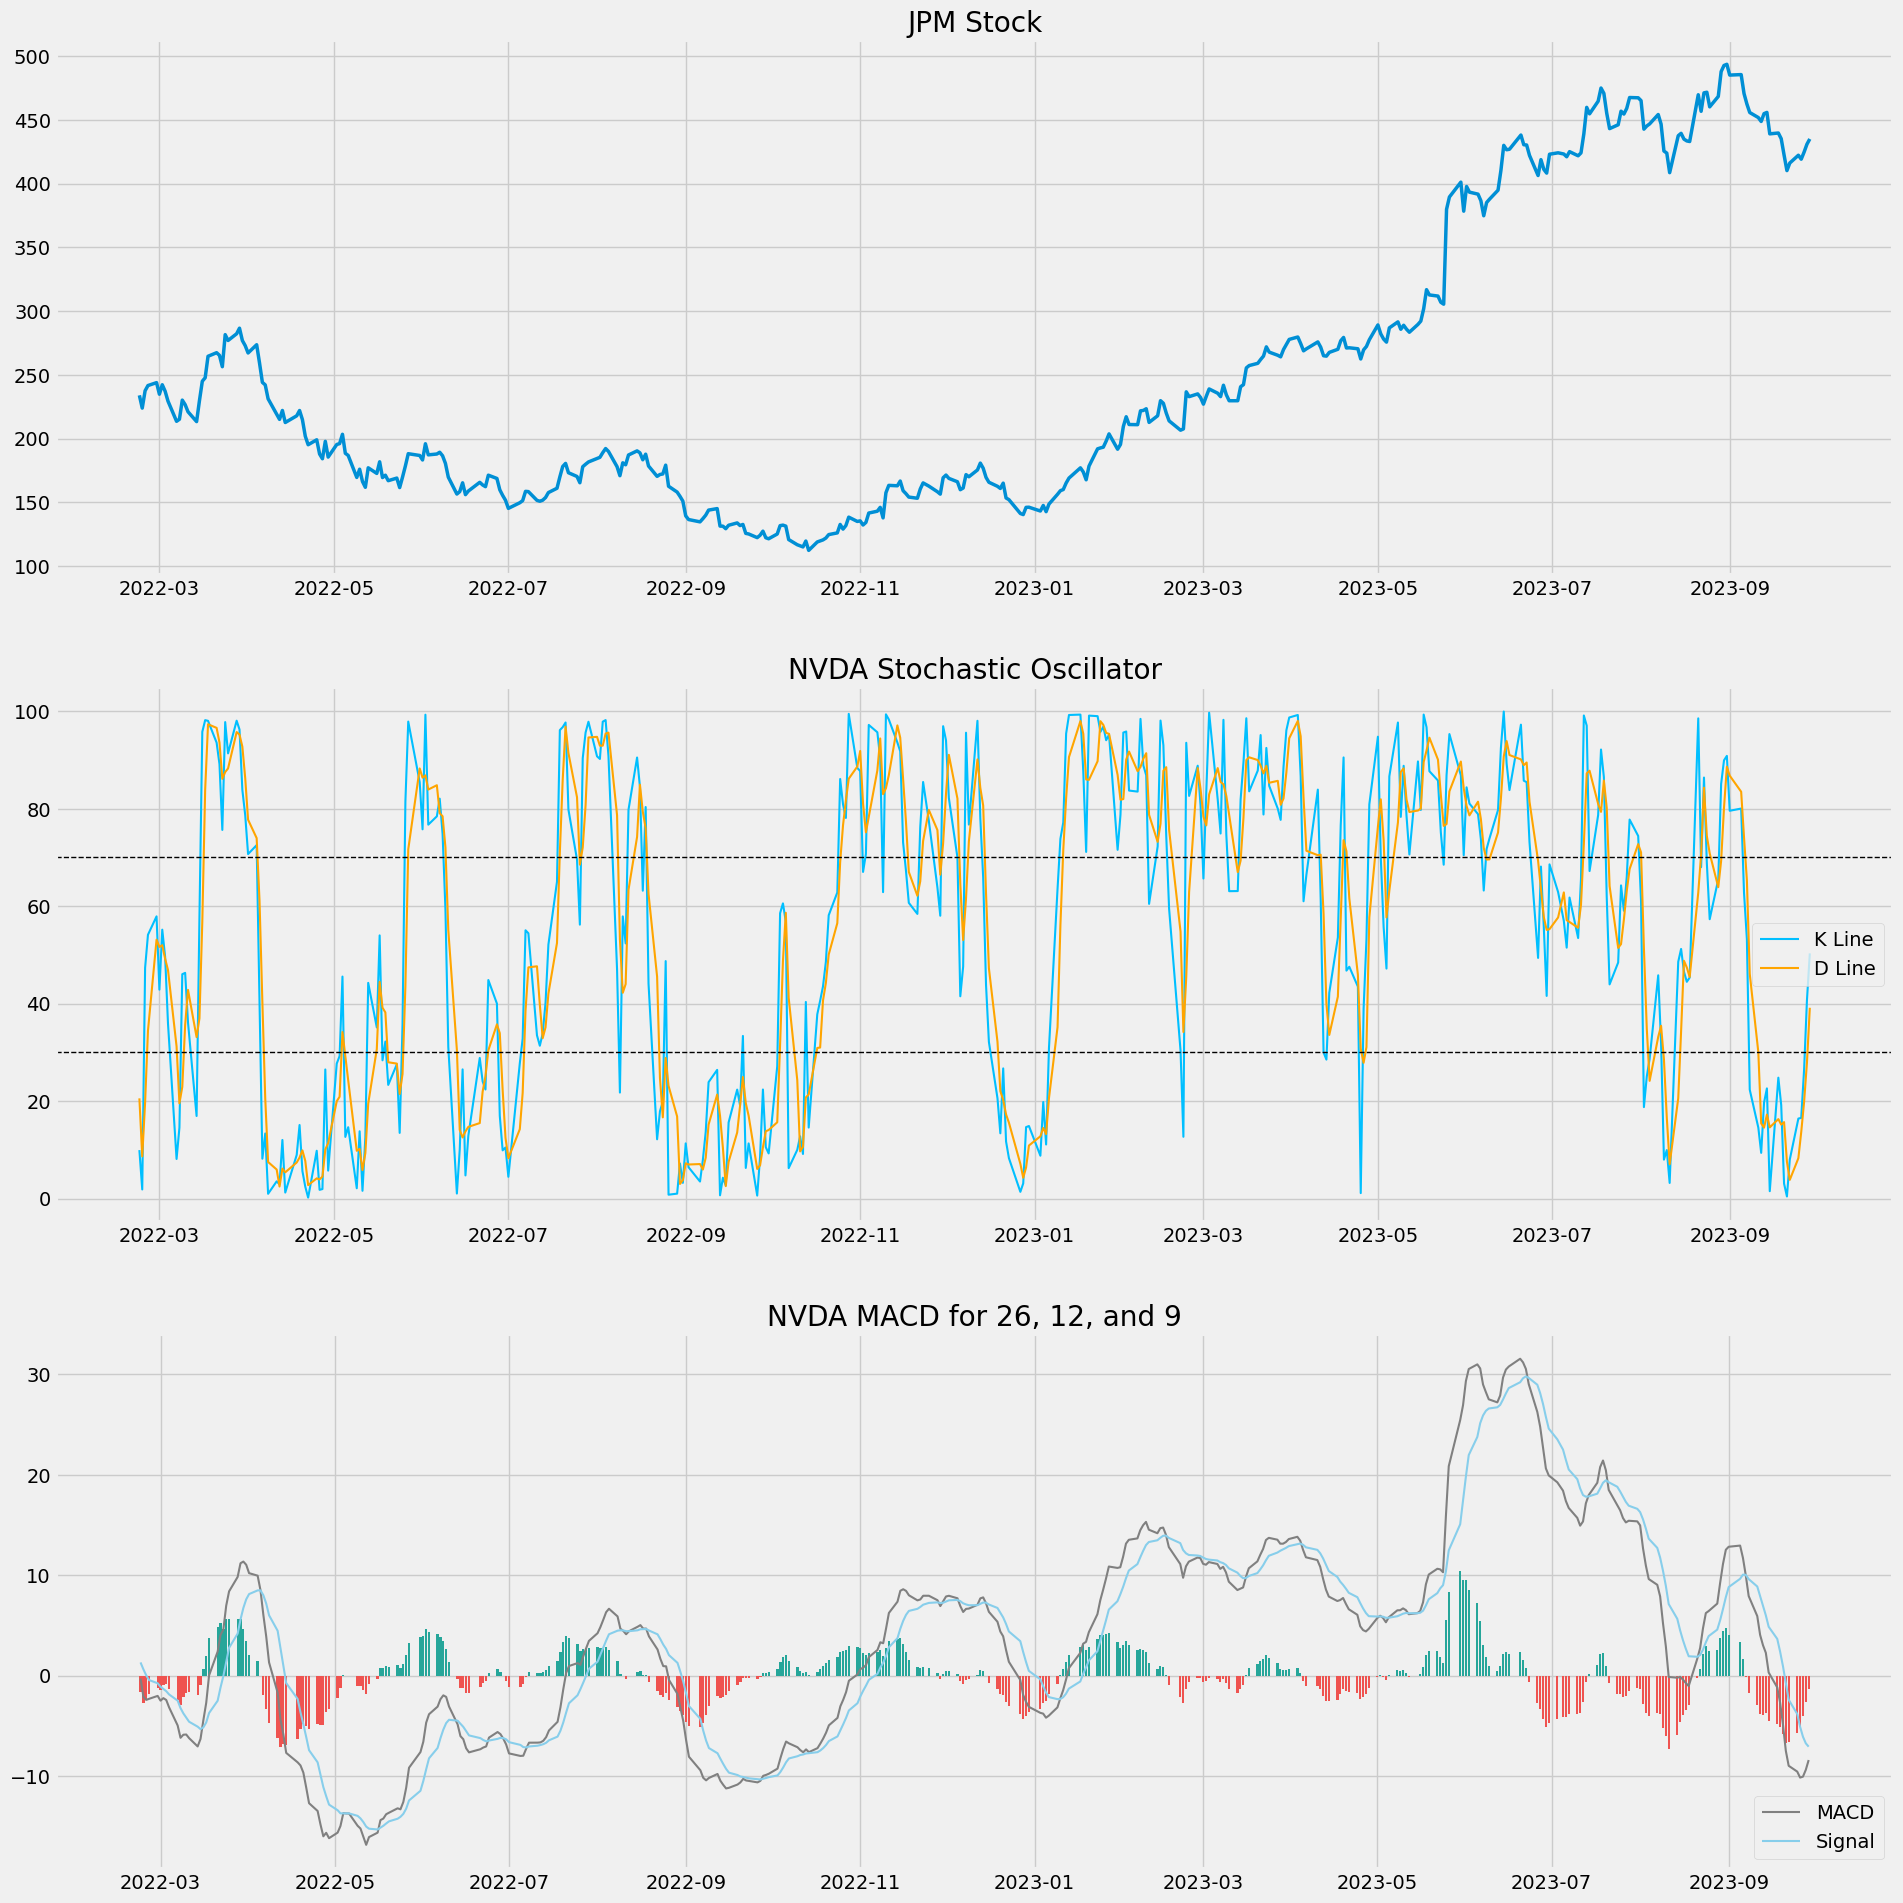

In [7]:
initial_capital = 200000
double_cross_algo_trader = DoubleCross("/content/MyDrive/MyDrive/Colab Notebooks/SSMIF/Fall2023 Challenge/cleaned_data.xlsx",initial_capital)
double_cross_algo_trader.init_trade()
double_cross_algo_trader.plot_indicators()

### Quick Notes
Its very clear this strategy more often or not will be by **FAR** more profitable in the long run than in the short run. What I mean specifically is range of trading, for example when applying my strategy to one of the portfolio stocks J.P. Morgan (JPM) I had average a profit of 29% when starting from June 30th 2022 as compared to lowering the range of trading I would average a loss of about 7%. While tech stocks perform conciderably better, as above my strategy was able to get a 8% profit from the end of June to the end of September. Regardless this is incredible to me.

## Plot P/L

In the graph below, due to the nature of the Doubel Cross strategy it makes sense that the only points here will be buy's, if we extend this range to about a year one will see multiple selling points throughout as Double Cross is a moving average salary with mine using a Stochastic Oscillator and MACD.

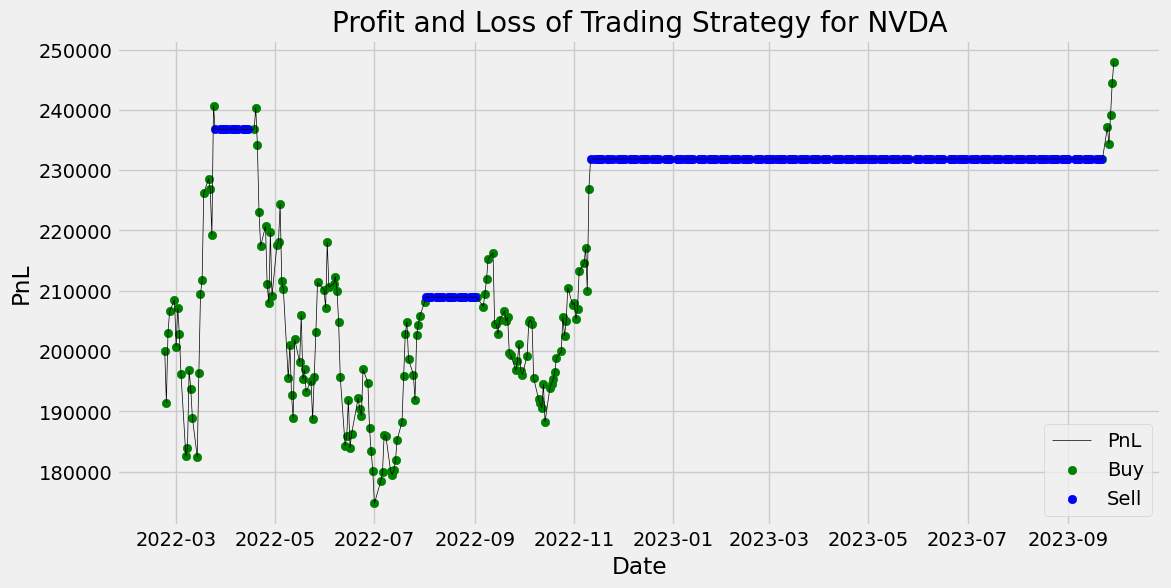

In [8]:
double_cross_algo_trader.plot_pnl(double_cross_algo_trader.trade_strat)

## Plot Liquidity

In the liqudity graph below, there may be multiple discrepencies on how exactly it was calucluated based on the overall pattern that is provided in this short time range, how I went about is dividing the remaining cash on hand plus the total assets I have bought by the remaining capital I have, similar to my portfolio analysis and it produced this graph below.

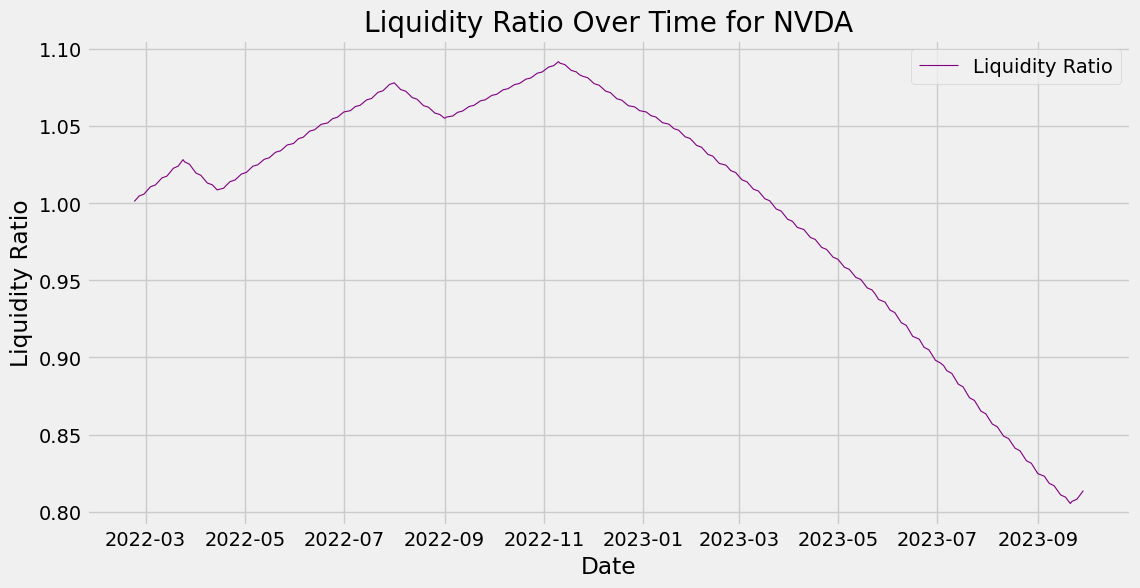

In [9]:
double_cross_algo_trader.plot_liquidity(double_cross_algo_trader.trade_strat)